# Data Exploration Notebook

## Objectives

* Perform univariate, bivariate and correlation analyses to explore the dataset’s structure, identify key relationships between variables and generate insights relevant to Business Requirement 1
    * Business Requirement 1: Data Insights (Conventional Analysis)  
        Identify key customer and loan attributes that are most correlated with loan default. Provide visual and statistical insights to help business analysts understand the primary drivers of credit risk.

## Inputs

* outputs/datasets/collection/LoanDefaultData.csv

## Outputs

* Generate code that answers Business Requirement 1 and can be used within the Streamlit App


---

In [1]:
# Ignore FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Load Data

As the variable `LoanID` is a unique identifier for each record, it does not contribute to the prediction and will therefore be dropped for the following analysis.

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")
    .drop(['LoanID'], axis=1)
    )
df.head(3)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,57,51244,180500,627,94,2,15.22,24,0.50,Master's,Full-time,Married,Yes,Yes,Auto,No,0
1,65,148892,194233,603,3,1,18.98,36,0.67,Bachelor's,Part-time,Married,No,No,Education,No,0
2,61,55177,163218,422,15,4,6.38,60,0.43,Bachelor's,Full-time,Single,No,No,Home,Yes,0


# Data Exploration

## Univariate Analysis

In this section we examine each variable individually, understand its distribution and check for missing levels. This helps us get a clear overview of the dataset before moving on to relationships between variables.

In [18]:
from ydata_profiling import ProfileReport

# Convert object columns to categorical so that it can be displayed properly in the report
df_cat = df.copy()
for col in df_cat.select_dtypes(include='object').columns:
    df_cat[col] = df_cat[col].astype('category')

# Also transform tagret variable to categorical
df_cat["Default"] = df_cat["Default"].astype('category')
    
pandas_report = ProfileReport(df=df_cat, minimal=True)
pandas_report.to_notebook_iframe() # needs: pip --upgrade setuptools and pip install notebook ipython==8.24.0  ipykernel ipywidgets

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* The profile report confirmed that the dataset contains no missing values
* Additionally, it shows that the variables `NumCreditLines` and `LoanTerm` are rather categorical variables than continuous numerical variables, as they have only a limited number of different values. They will be transformed for the following analyses

In [19]:
for col in ["NumCreditLines", "LoanTerm"]:
    df_cat[col] = df_cat[col].astype('category')

df_cat.dtypes

Age                  int64
Income               int64
LoanAmount           int64
CreditScore          int64
MonthsEmployed       int64
NumCreditLines    category
InterestRate       float64
LoanTerm          category
DTIRatio           float64
Education         category
EmploymentType    category
MaritalStatus     category
HasMortgage       category
HasDependents     category
LoanPurpose       category
HasCoSigner       category
Default           category
dtype: object

To make key observations easier to digest, additional univariate analyses were performed, highlighting distributions, skewness/kurtosis and class balance for both numerical and categorical features.

#### Distribution Analysis of Numerical Variables

In [7]:
import pandas as pd
import numpy as np

# Select numerical columns
num_cols = df_cat.select_dtypes(include=np.number).columns

# Create summary dataframe
summary = df_cat[num_cols].describe().T  # gives count, mean, std, min, 25%, 50%, 75%, max

# Add skewness
summary['skewness'] = df_cat[num_cols].skew()

# Optionally, add kurtosis
summary['kurtosis'] = df_cat[num_cols].kurtosis()

# Round for better readability
summary = summary.round(2)

summary

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Age,25534.0,43.65,14.99,18.0,31.0,44.00,57.00,69.0,-0.01,-1.19
Income,25534.0,82722.68,38973.61,15010.0,48872.5,82980.50,116294.00,149995.0,-0.01,-1.20
LoanAmount,25534.0,128023.05,70867.77,5015.0,66505.5,128037.50,189014.50,249989.0,-0.00,-1.20
CreditScore,25534.0,574.72,158.83,300.0,437.0,574.00,712.00,849.0,0.01,-1.20
MonthsEmployed,25534.0,59.74,34.75,0.0,29.0,60.00,90.00,119.0,-0.01,-1.20
InterestRate,25534.0,13.45,6.65,2.0,7.7,13.38,19.25,25.0,0.02,-1.21
DTIRatio,25534.0,0.50,0.23,0.1,0.3,0.50,0.70,0.9,-0.00,-1.20


* The numerical variables in the dataset show a generally well-balanced distribution pattern. All features have skewness values close to 0 and slightly negative kurtosis values around −1.2, indicating approximately symmetric distributions with light tails
* Comparing the mean values between features reveals that vary greatly in scale, with values ranging from over 100,000 for LoanAmount to around 0.5 for DTIRatio. This indicates that feature scaling will be necessary before modeling, as many machine learning algorithms are sensitive to differences in feature magnitude and may otherwise assign disproportionate importance to larger-scale variables

The following boxplots confirm these observations:

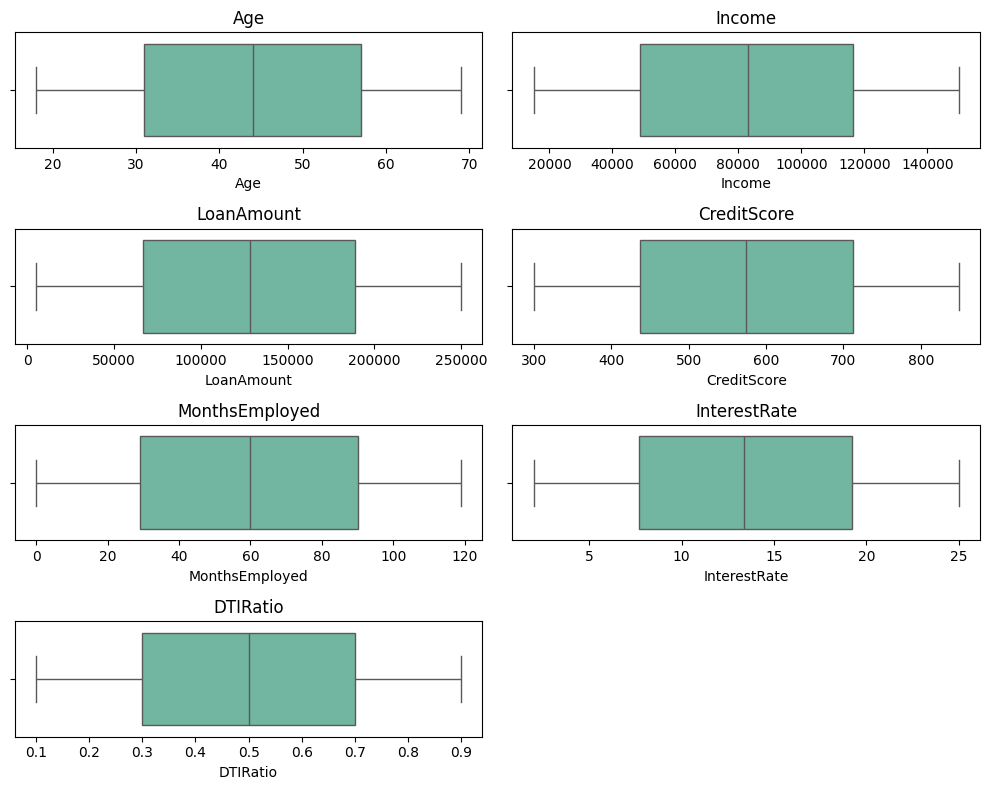

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_cat.select_dtypes(include=['float64', 'int64']).columns
n_cols = 2  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*2))
axes = axes.flatten()  # flatten 2D array for easy indexing

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_cat[col], ax=axes[i], color=sns.color_palette("Set2")[0])
    axes[i].set_title(f"{col}")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* In addition to the previous observations, the boxplots confirm that there are no outliers within the numerical features

#### Distribution Analysis of Categorical Variables

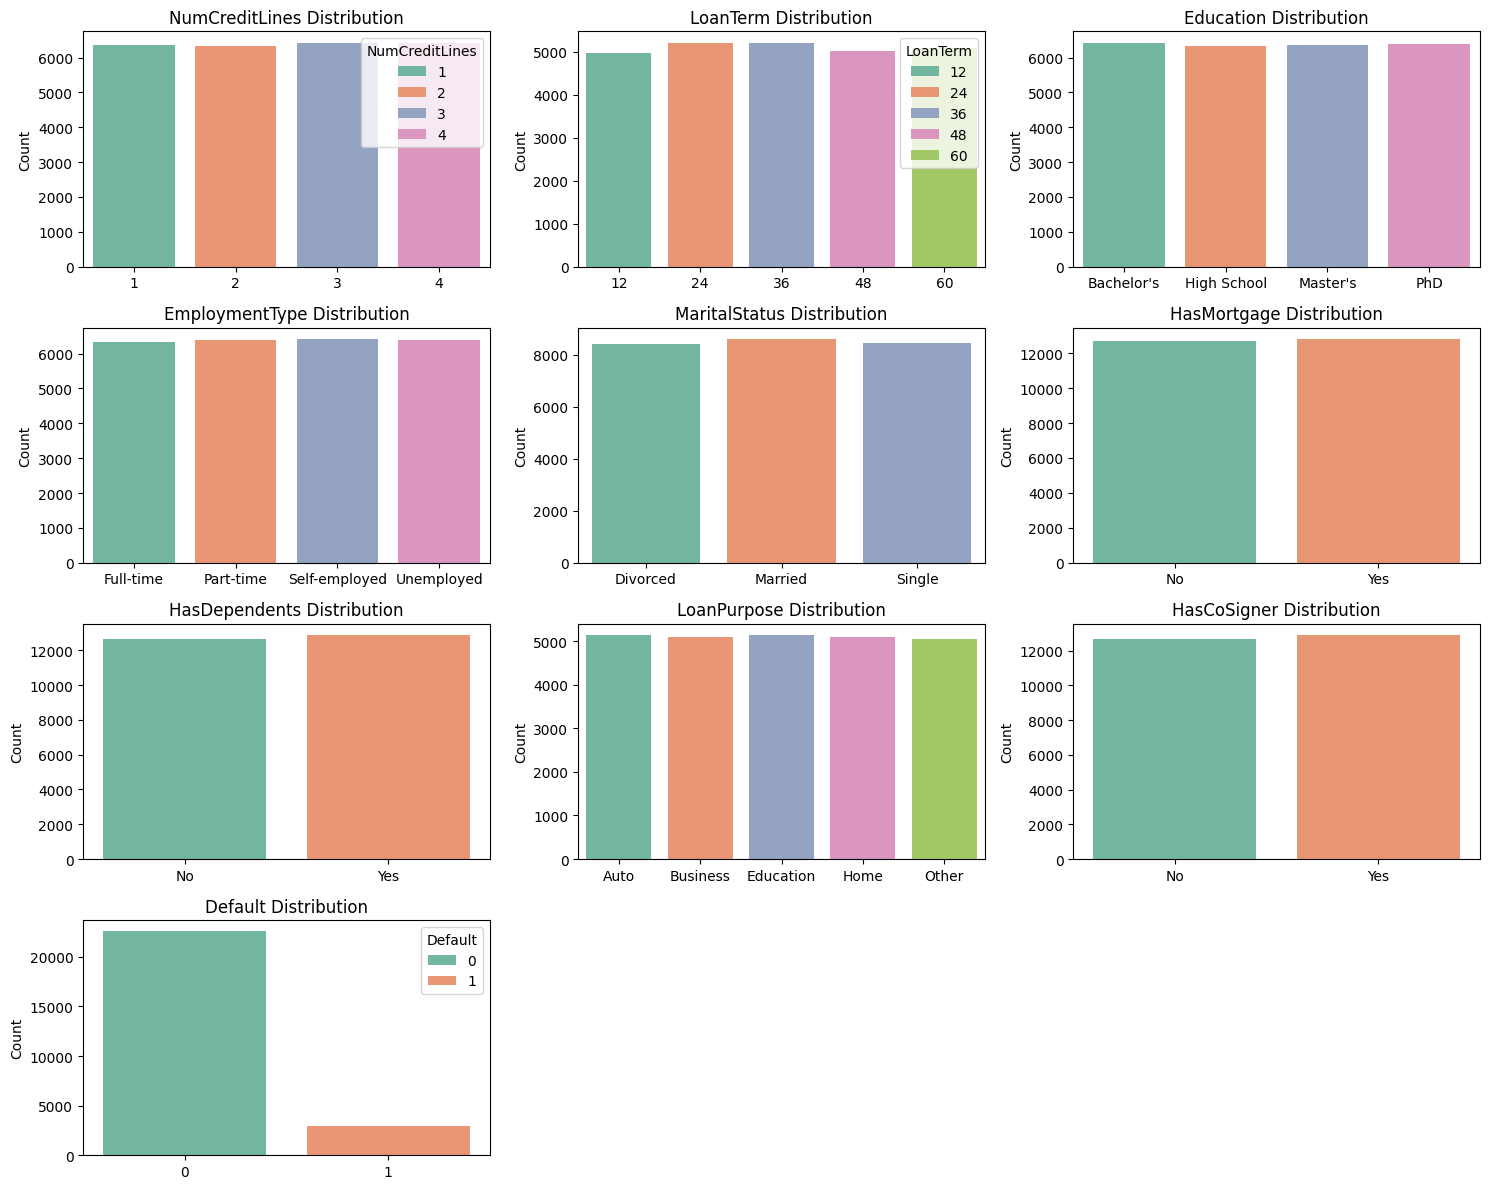

In [9]:
# Select categorical columns
cat_cols = df_cat.select_dtypes(include='category').columns.tolist()

# Grid layout for plots
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_cat, ax=axes[i], hue=col, palette='Set2')
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* The categorical variables in the dataset are generally well balanced, with each feature containing only 2–5 distinct classes. This indicates that the features are not overly granular, making them suitable for analysis and modeling. 
* The exception is the target variable `Default`, which is imbalanced toward 0 (non-default), reflecting that the majority of borrowers in the dataset did not default, what could already be seen in the "Data Collection" Notebook in the "Target Variable Exploration" section.

Overall, the distribution analysis confirms that:
* The numerical as well as categorical predictors are well-balanced and suitable for further modeling without extensive preprocessing
* The target imbalance in `Default` should be addressed later during model development

---

## Bivariate Analysis

After examining the univariate distributions to understand each feature individually, the next step is to explore how variables relate to the target variable.

#### Distribution Analysis of Numerical Variables

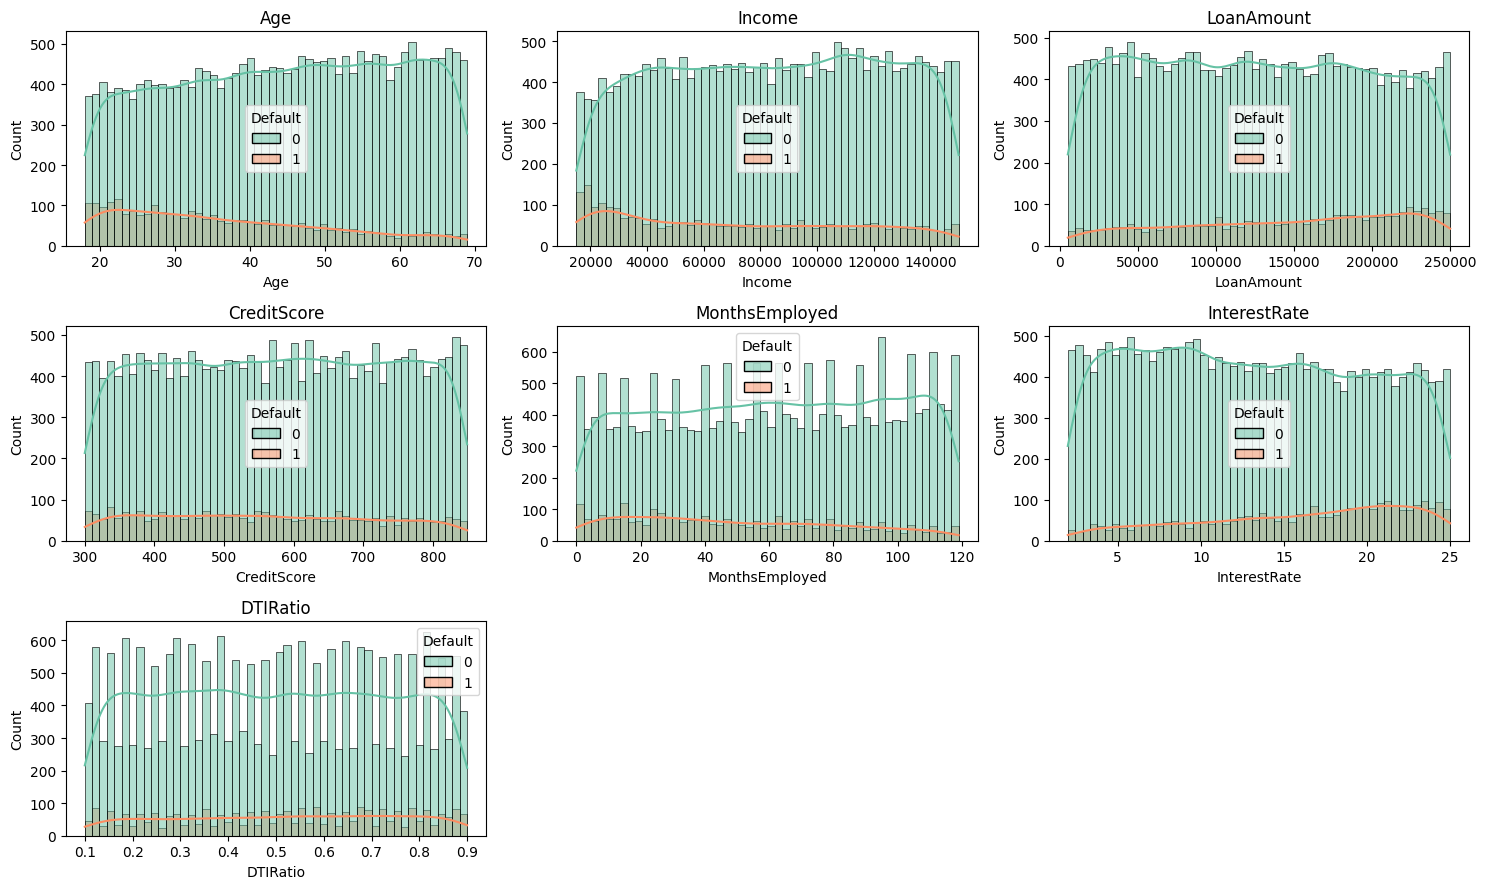

In [20]:
numeric_cols = df_cat.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()  # flatten 2D array for easy indexing

# set bins to Age range so histogram appears without gaps
bins = (df_cat["Age"].max() - df_cat["Age"].min()) + 1

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_cat, x=col, hue="Default", ax=axes[i], kde=True, bins = bins, palette="Set2")
    axes[i].set_title(f"{col}")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Distribution Analysis of Categorical Variables

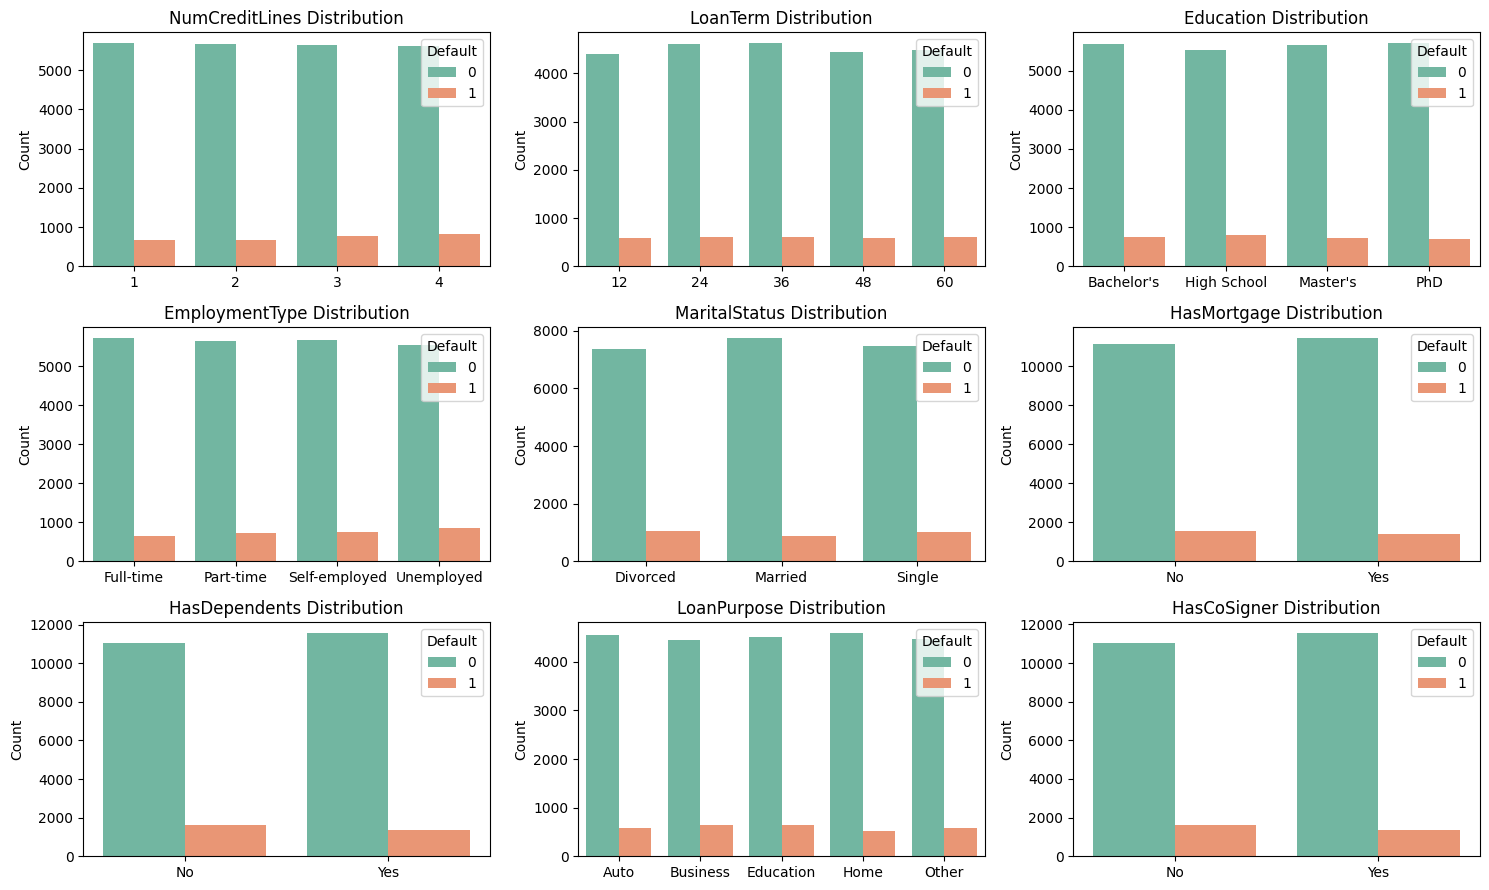

In [21]:
cat_cols = df_cat.select_dtypes(include='category').columns.drop("Default").tolist()

# Grid layout for plots
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_cat, ax=axes[i], hue="Default", palette='Set2')
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* The bivariate analysis revealed that several numerical variables, such as Age, Income, and MonthsEmployed, show clear positive or negative relationships with `Default`. This suggests that these features may have some predictive influence on the target variable. In contrast, categorical variables display much weaker and less consistent patterns, indicating that their effect on `Default` is less direct or may depend on interactions with other variables.

Next, we explore correlation analyses to quantify these relationships and further understand how the features relate to each other and to the target variable.

## Correlation Analysis

Correlation analysis helps identify linear or non-linear relationships between features and with the target variable.

This step provides insights into potential multicollinearity among predictors and highlights which variables may have predictive influence on loan default.
Understanding these relationships is essential for guiding feature selection, hypothesis validation and the design of machine learning models later in the project. We will also use these insights to answer Business Requirement 1.

To explore how features relate to each other and to the target variable, we use three complementary measures:

* Pearson correlation: captures linear relationships
* Spearman correlation: captures monotonic (rank-based) relationships
* Power Predictive Score (PPS): detects non-linear and directional predictive relationships

Since each method provides a different perspective, comparing all three helps ensure we capture both linear and complex dependencies in the data.

The helper functions below automate this process:

* heatmap_corr() → Plots correlation matrices (Pearson or Spearman) masking for low-correlation values
* heatmap_pps() → Plots the PPS matrix masking for low-correlation values
* CalculateCorrAndPPS() → Calculates Pearson, Spearman and PPS matrices and prints descriptive statistics for PPS to help select masking thresholds
* DisplayCorrAndPPS() → Combines all plots in one view to facilitate interpretation and comparison

Together, these functions provide a structured way to assess relationships among variables and evaluate which features may be most predictive of loan default.

In [13]:
# From Churnometer Walkthrough Project
import numpy as np
# for vs code
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='Set2', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='Set2', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.ylabel("")
        plt.xlabel("")
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='y', index='x', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable is correlated with other variables (features and target)")
    print("* Analyse multi-collinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("Evaluates monotonic relationships (continuous variables)\n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("Evaluates linear relationships (continuous variables)\n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two variables\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [14]:
# transform target back to integer so that it can be used in pearson and spearman correlation analysis
df_cat["Default"] = df_cat["Default"].astype('int')
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_cat)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  272.0  0.003  0.008  0.0  0.0  0.0  0.0  0.053


The PPS summary shows that most variable pairs have no correlation, while a few reach slightly higher values (up to 0.023), indicating some predictive potential. 

Based on this, a PPS threshold of 0.001 was chosen to filter out zero relationships while highlighting pairs with above-average minimal predictive power. 

Analogously, for the Pearson and Spearman correlation heatmaps, a threshold of 0.01 was selected to capture the minimal available correlations.



* Analyse how the target variable is correlated with other variables (features and target)
* Analyse multi-collinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
Evaluates monotonic relationships (continuous variables)



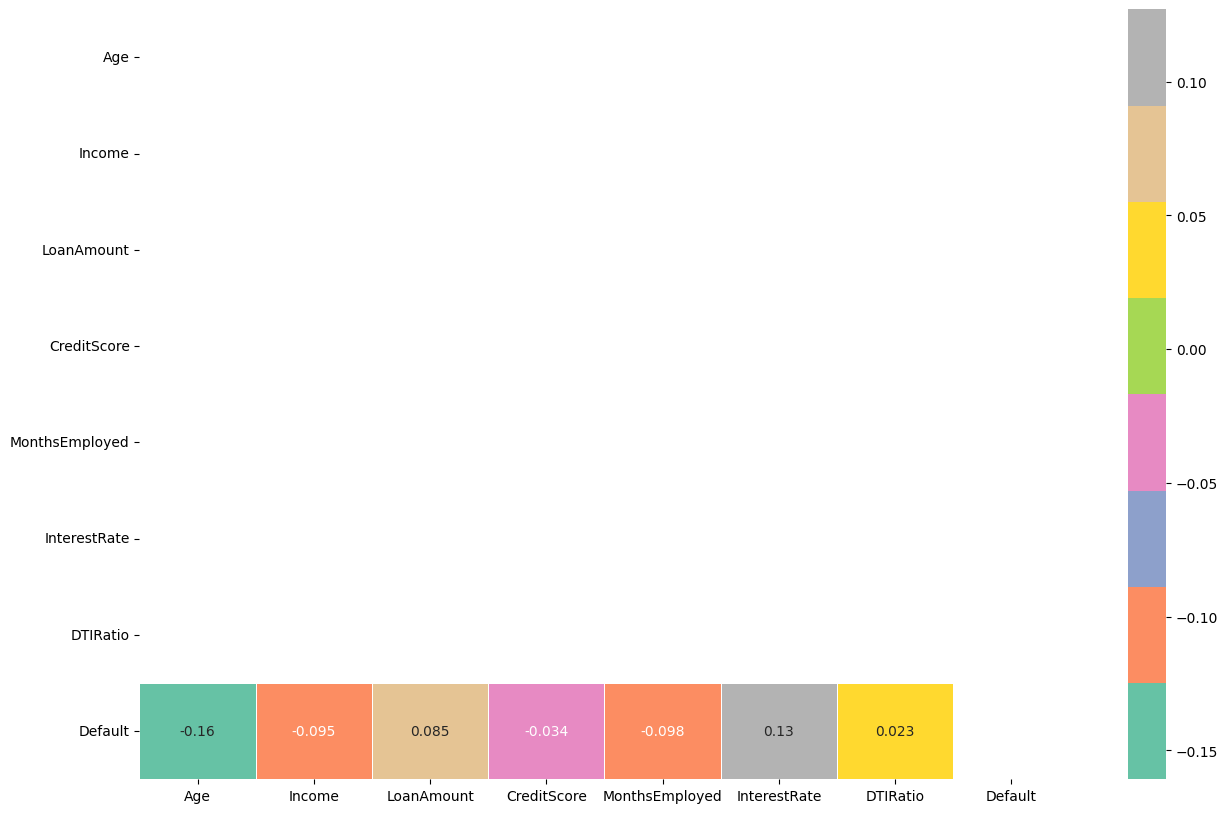



*** Heatmap: Pearson Correlation ***
Evaluates linear relationships (continuous variables)



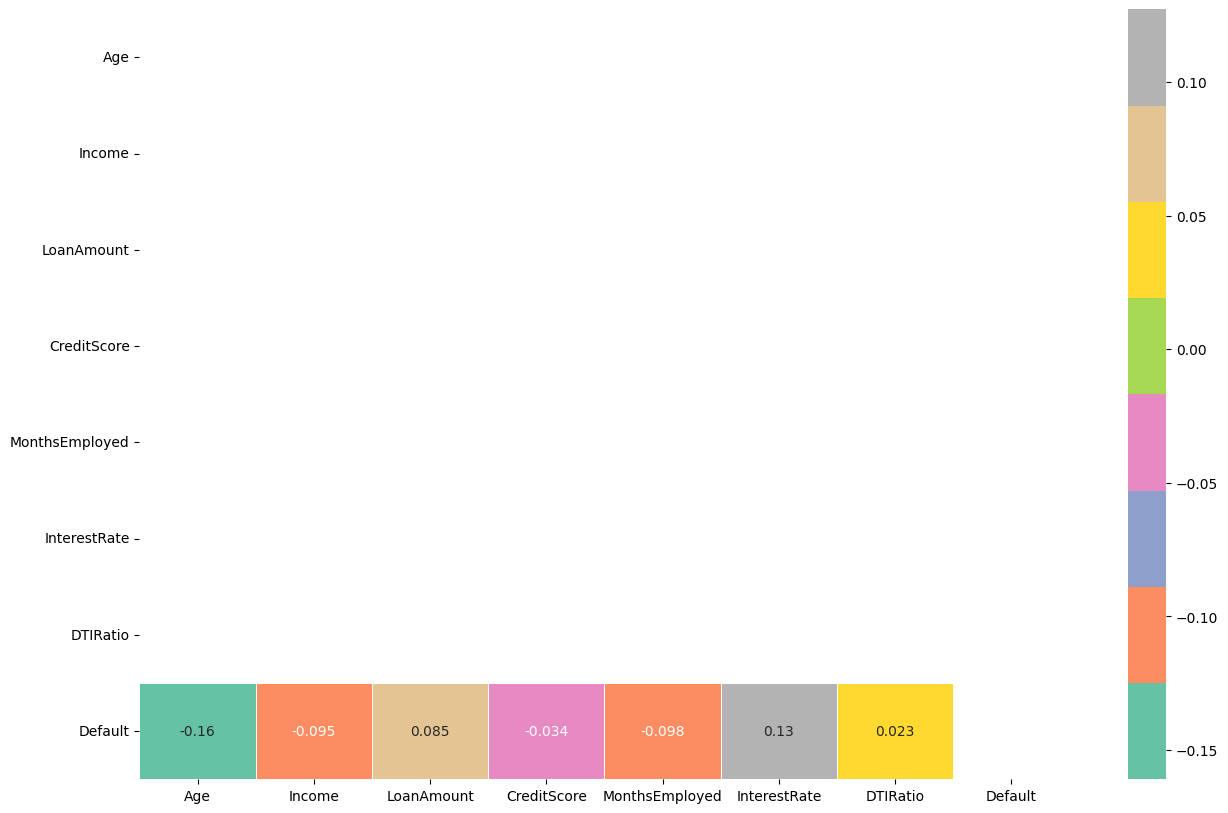



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two variables
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



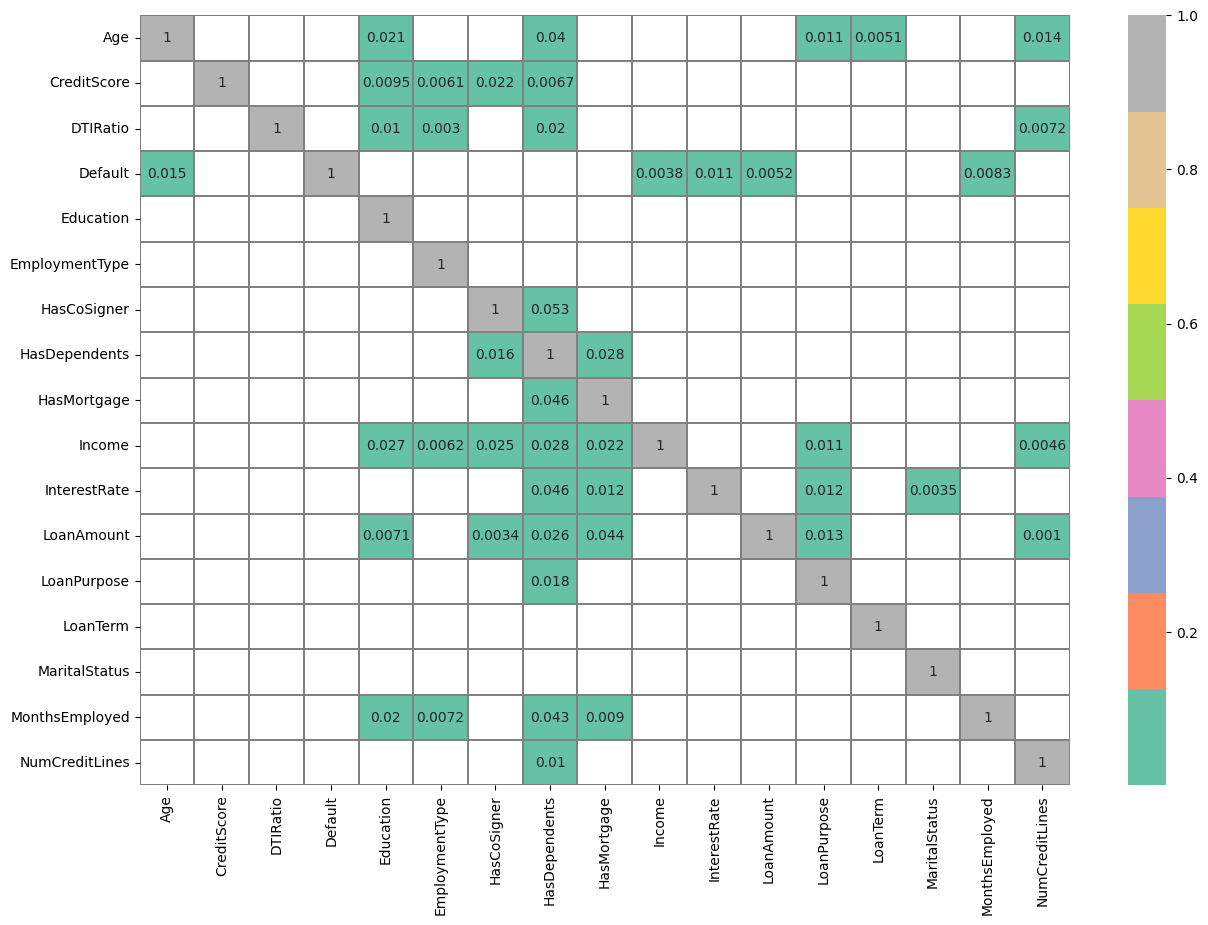

In [ ]:
CorrThreshold = 0.03
PPS_Threshold = 0.001
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = CorrThreshold, PPS_Threshold = PPS_Threshold,
                  figsize=(15,10), font_annot=10)

* The correlation and PPS heatmaps show generally low correlations among predictors and with the `Default` variable. 
This indicates that multicollinearity is not a major concern, but also that no single variable strongly explains loan default. 
Instead, default behavior is likely influenced by a combination of factors.
* The variables that showed at least some predictive power on the target variable are listed below, ordered by their Pearson correlation with the target variable

In [16]:
# Collect variables with some predictive signal from PPS and correlations
pps_vars = pps_matrix.T["Default"][abs(pps_matrix["Default"]) > PPS_Threshold].drop("Default").index
pearson_vars = df_corr_pearson["Default"][abs(df_corr_pearson["Default"]) > CorrThreshold].drop("Default").index
spearman_vars = df_corr_spearman["Default"][abs(df_corr_pearson["Default"]) > CorrThreshold].drop("Default").index

# Combine all and remove duplicates
focus_vars = pd.Index(pps_vars).union(pearson_vars).union(spearman_vars)

# Sort by absolute Pearson correlation with Default
focus_vars = df_corr_pearson["Default"][focus_vars].sort_values(key=abs, ascending=False)
print("The feature with highest predictive power, ordered by absolute Pearson correlation:")
print(focus_vars)

focus_vars = focus_vars.index.tolist()


The feature with highest predictive power, ordered by absolute Pearson correlation:
Age              -0.160921
InterestRate      0.127190
MonthsEmployed   -0.098215
Income           -0.095038
LoanAmount        0.085311
CreditScore      -0.033939
DTIRatio          0.022528
Name: Default, dtype: float64


* The correlation analysis confirms the patterns observed in the bivariate analysis. The variables with the strongest correlations are all numerical, indicating that numerical features have a greater influence on default than categorical ones.

Next we visualize how the identified variables relate to the target. This complements the correlation analysis by showing the actual distributions and highlighting patterns or imbalances that may influence predictive modeling.

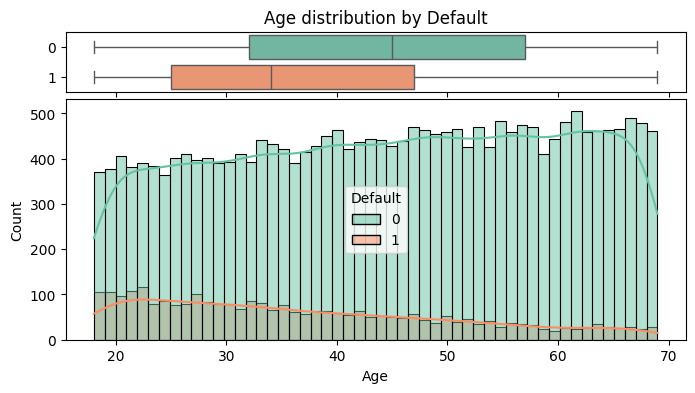

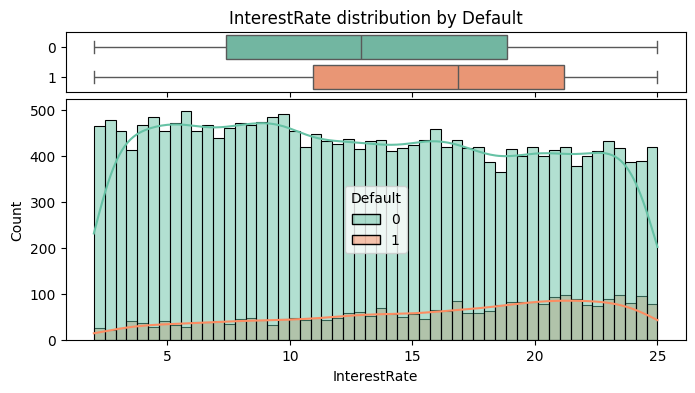

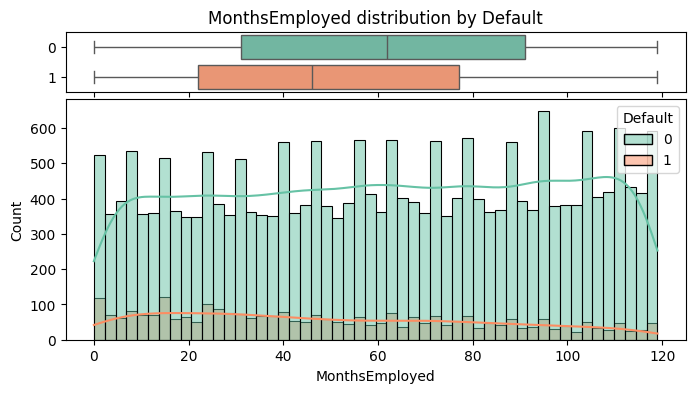

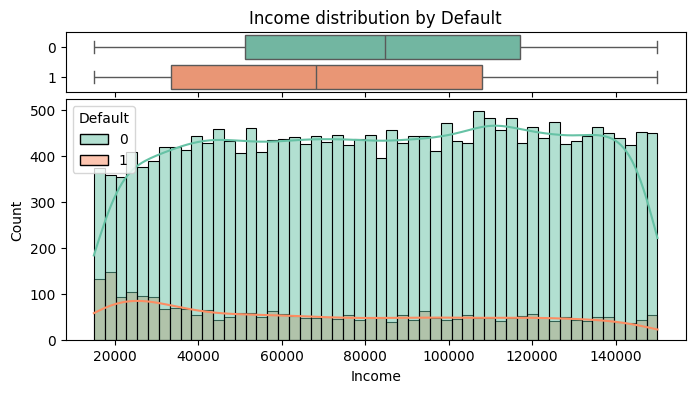

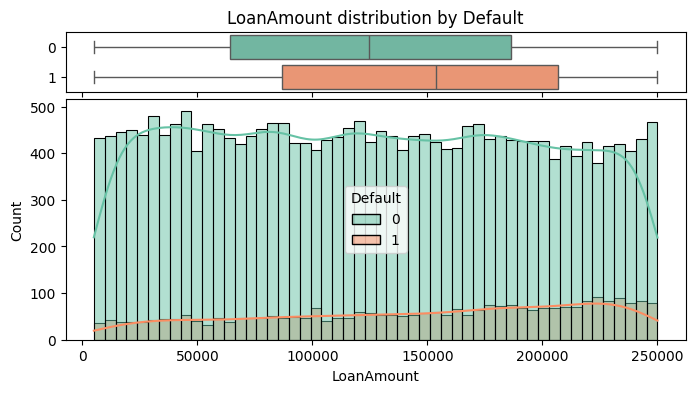

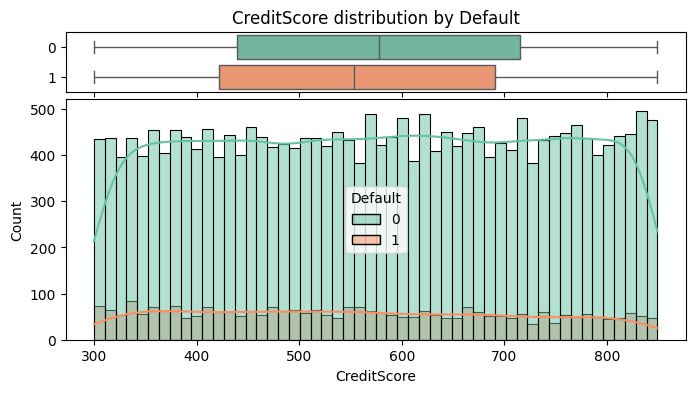

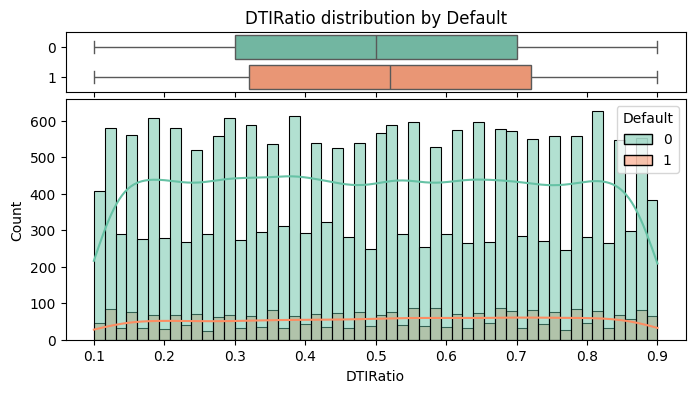

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

target_var = 'Default'

for col in focus_vars:
    # Create a figure with two stacked axes (boxplot above histogram)
    # Source: https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/
    fig, (ax_box, ax_hist) = plt.subplots(
        2, 1, 
        figsize=(8, 4), 
        gridspec_kw={"height_ratios": [0.25, 1], "hspace": 0.05}
    )

    # Boxplot (small on top)
    sns.boxplot(data=df_cat, x=col, y=target_var, hue=target_var, orient="h", ax=ax_box, palette="Set2", legend=False)
    ax_box.set(xlabel="")  
    ax_box.set_ylabel("")  
    ax_box.set_title(f"{col} distribution by {target_var}", fontsize=12)

    # Histogram (main plot)
    # set bins to Age range so histogram appears without gaps
    bins = (df_cat["Age"].max() - df_cat["Age"].min()) + 1
    sns.histplot(data=df_cat, x=col, hue=target_var, kde=True, ax=ax_hist, bins=bins, palette="Set2")
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel("Count")
    ax_hist.set_title("")

    plt.show()


* Borrowers who default tend to show the following general trends:
    * Younger age
    * Higher interest rates
    * Lower income
    * Shorter employment duration
    * Larger loan amounts
    * Slightly lower Credit Scores
* This doesn't mean all defaulting customers have all these patterns at the same time, we just noticed a general trend
* The `CreditScore` shows only a weak relationship with `Default`, indicating that its influence on predicting default risk is relatively minor compared to the other variables

---

# Conclusions and Next Steps

The univariate and correlation analyses provided an initial understanding of the data distribution and key variable relationships with the target.

In the univariate analysis we could observe that `NumCreditLines` and `LoanTerm` need to be treated as categorical variables. Additionally, we saw that all variables except the target are well-balanced and suitable for further modeling without extensive preprocessing. The target imbalance in `Default` and also the largely different scales between the numerical variables should be addressed later during model development.

The correlations between the features and the target variable are low, which indicates that multicollinearity is not a major concern, but also that no single variable strongly explains loan default.

The analysis nevertheless showed that borrowers who default tend to show the following general trends:
* Younger age
* Higher interest rates
* Lower income
* Shorter employment duration
* Larger loan amounts
* Slightly lower Credit Scores

Next Steps:
* Conduct data cleaning activities
* Prepare data for feature engineering and modeling: scaling numerical variables, encoding categorical features, and creating new derived features if needed.